In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50
from sklearn.model_selection import train_test_split
import json

In [3]:
#torch.cuda.set_device(2)

In [4]:
torch.backends.cudnn.benchmark=True

## Data

In [5]:
PATH = Path('/home/giles/Downloads/fastai_data/salt/')
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
masks_csv = pd.read_csv(PATH/MASKS_FN)
meta_csv = pd.read_csv(PATH/META_FN, index_col='id')

In [6]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [7]:
(PATH/'train_masks-128').mkdir(exist_ok=True)

In [8]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train_masks-128'/fn.name)

files = list((PATH/'train_masks').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

In [9]:
(PATH/'train-128').mkdir(exist_ok=True)

In [10]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train-128'/fn.name)

files = list((PATH/'train').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

In [11]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'
sz = 32
bs = 64
nw = 16

TRAIN_DN = 'train'
MASKS_DN = 'train_masks_png'
sz = 128
bs = 64
nw = 16

In [12]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [13]:
x_names = np.array(glob(f'{PATH}/{TRAIN_DN}/*'))
y_names = np.array(glob(f'{PATH}/{MASKS_DN}/*'))

## Validation split

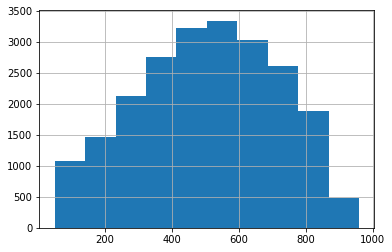

In [14]:
meta_csv['z'].hist()

In [15]:
meta_csv['depth_bin'] = 0
for d in range(1,5):
    meta_csv.loc[meta_csv.z >= 200*d, 'depth_bin'] = d

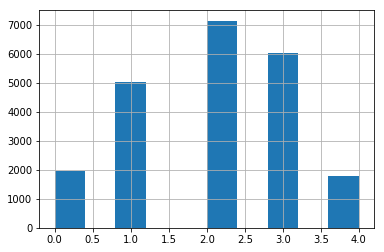

In [16]:
meta_csv['depth_bin'].hist()

In [17]:
trainIds = [x[x.rfind('/')+1:x.rfind('.')] for x in x_names]

In [18]:
trainIds

['d2b40a2781',
 '89dba191b1',
 'e6ac2a35cd',
 '236a5cc090',
 'f30e47cb36',
 'e0bde1cf11',
 'ad16edc8be',
 'fa92bed2b1',
 '6d46f994ac',
 'eabed5b2b4',
 '1cad8c327b',
 '2fe4adfd48',
 '24d67576d0',
 '60b3d0d613',
 'c32752c00f',
 '0ab5e14937',
 '6738d474a3',
 '9d98768f19',
 'b5893fc541',
 'e337021e6a',
 '7f0bdb5e31',
 'ff9b7d0d2e',
 '25bd98aec3',
 '24bf79cd1e',
 'd66e51d456',
 'dae1555fbf',
 '9a71e8563b',
 'eb4efc4c39',
 '657f2c34f7',
 '0ce8a6ae62',
 '8d89d465fc',
 '4bb8260218',
 '921b60e76d',
 'f5c2e66754',
 '7eb42fe5ec',
 'fea1ff8505',
 '2fe0292eea',
 'c5493cc7b0',
 '8b44342fd9',
 'badb3ea766',
 '730eee262c',
 '46673b0e2d',
 '21df07989f',
 '7fc1ce1cb4',
 'a4e90eef39',
 '312c4ce754',
 'e8b730fe92',
 '499560e566',
 'f62410bce9',
 '2b76b47947',
 '39400e0443',
 'f87154ea7b',
 '40aaac97b1',
 '0589f557d7',
 '15d76f1672',
 '7a0c8915be',
 'de261976e6',
 'e8d6412ed8',
 'c82dabf9b1',
 'a1e32a6815',
 '4a12baccc4',
 '59597a8431',
 '54cfa66336',
 '6edb010212',
 'de7202d286',
 'd567ba2b49',
 '43a1dbb0

In [19]:
train_csv = meta_csv[meta_csv.index.isin(trainIds)]

In [20]:
train_csv.head()

,z,depth_bin
id,,
4ac19fb269,306,1
1825fadf99,157,0
f59821d067,305,1
5b435fad9d,503,2
e340e7bfca,783,3


In [21]:
len(x_names), len(train_csv)

(4000, 4000)

In [22]:
print(trainIds[0:10])
train_csv.reindex(trainIds)

['d2b40a2781', '89dba191b1', 'e6ac2a35cd', '236a5cc090', 'f30e47cb36', 'e0bde1cf11', 'ad16edc8be', 'fa92bed2b1', '6d46f994ac', 'eabed5b2b4']


,z,depth_bin
id,,
d2b40a2781,587,2
89dba191b1,567,2
e6ac2a35cd,506,2
236a5cc090,676,3
f30e47cb36,368,1
e0bde1cf11,184,0
ad16edc8be,509,2
fa92bed2b1,810,4
6d46f994ac,676,3


In [23]:
idxs = train_test_split(range(len(x_names)), test_size=0.2, stratify=train_csv['depth_bin'])
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(idxs[1], x_names, y_names)

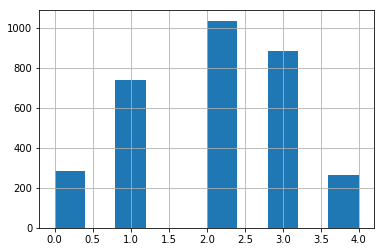

In [24]:
train_csv['depth_bin'].iloc[idxs[0]].hist()

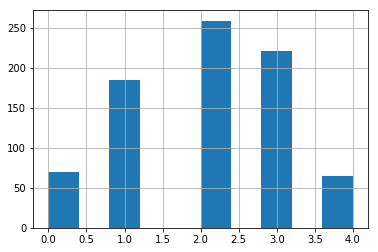

In [25]:
train_csv['depth_bin'].iloc[idxs[1]].hist()

In [26]:
aug_tfms = [RandomFlip(tfm_y=TfmType.CLASS)]

In [27]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [28]:
x,y = next(iter(md.trn_dl))

In [29]:
x.shape,y.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64, 32, 32]))

In [30]:
denorm = md.val_ds.denorm

In [31]:
def show_aug_img(ims, idx, figsize=(5,5), normed=True, ax=None, nchannels=3):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    if normed: ims = denorm(ims)
    else:      ims = np.rollaxis(to_np(ims),1,nchannels+1)
    ax.imshow(np.clip(ims,0,1)[idx])
    ax.axis('off')

In [32]:
batches = [next(iter(md.aug_dl)) for i in range(9)]

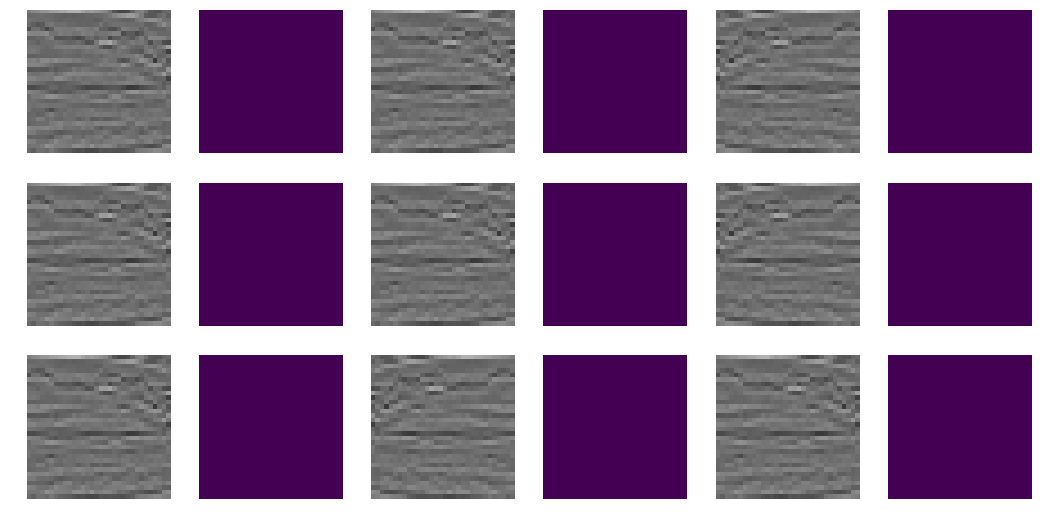

In [33]:
fig, axes = plt.subplots(3, 6, figsize=(18, 9))
for i,(x,y) in enumerate(batches):
    show_aug_img(x,1, ax=axes.flat[i*2])
    show_aug_img(y,1, ax=axes.flat[i*2+1], nchannels=1, normed=False)

## Simple upsample

In [34]:
f = resnet34
cut,lr_cut = model_meta[f]

In [35]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [36]:
def dice(pred, targs):
    pred = (pred>0.5).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

## U-net (ish)

In [37]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [38]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [39]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [40]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

## Training loop

In [41]:
def trainModel(uid, models, trn_x, trn_y, val_x,val_y, aug_tfms, lr=2e-2, wd=1e-7, bs=64):
    ##32
    print('Running on 32x32')
    sz = 32
    tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
    md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
    denorm = md.trn_ds.denorm
    
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    learn.crit=nn.BCEWithLogitsLoss()
    learn.metrics=[dice, accuracy_thresh(0.5)]
    
    learn.freeze_to(1)
    lrs = np.array([lr/9,lr/3,lr])
    learn.fit(lr,1,wds=wd,cycle_len=8,use_clr=(5,8), best_save_name='tmp')
    learn.load('tmp')
    learn.unfreeze()
    learn.bn_freeze(True)
    learn.fit(lrs/2, 1, wds=wd, cycle_len=20,use_clr=(20,10), best_save_name='tmp')
    
    ##64
    print('Running on 64x64')
    sz = 64
    tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
    md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
    
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    learn.crit=nn.BCEWithLogitsLoss()
    learn.metrics=[dice, accuracy_thresh(0.5)]
    learn.load('tmp')
    
    learn.freeze_to(1)
    learn.fit(lr/2,1,wds=wd, cycle_len=10,use_clr=(10,10), best_save_name='tmp')
    learn.load('tmp')
    learn.unfreeze()
    learn.bn_freeze(True)
    learn.fit(lrs/4,1,wds=wd, cycle_len=8,use_clr=(20,8), best_save_name='tmp')
    
    ##128
    print('Running on 128x128')
    sz = 128
    tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
    md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
    
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    learn.crit=nn.BCEWithLogitsLoss()
    learn.metrics=[dice, accuracy_thresh(0.5)]
    learn.load('tmp')
    
    learn.freeze_to(1)
    learn.fit(lr/2,1, wds=wd, cycle_len=6,use_clr=(6,4), best_save_name='tmp')
    learn.load('tmp')
    learn.unfreeze()
    learn.bn_freeze(True)
    learn.fit(lrs/5,1, wds=wd,cycle_len=8,use_clr=(20,8), best_save_name='tmp')
    learn.load('tmp')
    learn.fit(lrs/5,5, wds=wd,cycle_len=1,cycle_mult=2, best_save_name='model_'+str(uid))

In [42]:
from sklearn.model_selection import KFold

In [43]:
nSplits = 10

In [44]:
kf = KFold(n_splits=nSplits, shuffle=True)
folds = kf.split(trn_x)
for i, (train, test) in enumerate(folds):
    print('_____________________________')
    print('Running fold', i+1,'/', nSplits)
    m_base = get_base()
    m = to_gpu(Unet34(m_base))
    models = UnetModel(m)
    trainModel(i, models, trn_x[train], trn_y[train], trn_x[test], trn_y[test], aug_tfms)
    print('_____________________________')

_____________________________
Running fold 1 / 10
Running on 32x32


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.342682   0.522793   0.70673    0.832678  
    1      0.285225   0.439797   0.560695   0.8388         
    2      0.261766   0.301855   0.783771   0.891464       
    3      0.233635   0.265678   0.798772   0.898776       
    4      0.214338   0.273391   0.754585   0.891037       
    5      0.204627   0.271959   0.802188   0.897266       
    6      0.179484   0.244787   0.789066   0.903287       
    7      0.163029   0.227368   0.807664   0.909665       



epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.19295    0.300937   0.730628   0.882037  
    1      0.213846   0.342378   0.751747   0.878354       
    2      0.211239   0.273253   0.709825   0.879852       
    3      0.194061   0.225072   0.770623   0.897809       
    4      0.183018   0.236074   0.810761   0.91301        
    5      0.167342   0.255074   0.798202   0.903851       
    6      0.184694   0.2954     0.752665   0.889392       
    7      0.192397   0.255371   0.824407   0.914493       
    8      0.170512   0.215926   0.818222   0.913162       
    9      0.152599   0.248259   0.818621   0.908423       
    10     0.13841    0.239526   0.822066   0.91163        
    11     0.11949    0.235546   0.828133   0.916495       
    12     0.113638   0.224795   0.840535   0.920026       
    13     0.096972   0.258245   0.821187   0.913275        
    14     0.088079   0.234881   0.839943   0.922229        
    15     0.081553   0.248073   0.837724  

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.270593   0.279183   0.733538   0.884477  
    1      0.226425   0.276916   0.712294   0.881184       
    2      0.201242   0.219772   0.811611   0.910929       
    3      0.178191   0.214775   0.821657   0.915481       
    4      0.162483   0.209665   0.822349   0.914526       
    5      0.155535   0.212262   0.837793   0.915504       
    6      0.145267   0.205289   0.827533   0.916982       
    7      0.134254   0.214655   0.855      0.925739       
    8      0.12326    0.20917    0.854482   0.924348       
    9      0.110698   0.208262   0.852103   0.925402       



epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.125937   0.188135   0.844899   0.926052  
    1      0.152147   0.220533   0.83031    0.918748       
    2      0.137087   0.213783   0.854571   0.922747       
    3      0.117017   0.196254   0.859168   0.931345       
    4      0.100658   0.195517   0.872673   0.931255       
    5      0.090289   0.189579   0.858043   0.92978         
    6      0.077639   0.17835    0.873296   0.935493        
    7      0.069503   0.172397   0.882147   0.93917         

Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.254444   0.214552   0.830911   0.918416  
    1      0.214391   0.20716    0.83799    0.922848       
    2      0.191494   0.197918   0.833787   0.922285       
    3      0.181404   0.19825    0.854729   0.928493       
    4      0.161397   0.180836   0.868301   0.933612       
    5      0.148111   0.161047   0.862293   0.933183       



epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.150928   0.17319    0.849829   0.93056   
    1      0.154437   0.148703   0.878575   0.939204       
    2      0.145878   0.168455   0.818789   0.915126       
    3      0.148693   0.162427   0.873599   0.936867       
    4      0.129477   0.135915   0.879449   0.941272       
    5      0.113303   0.153225   0.88545    0.941046       
    6      0.098234   0.133662   0.897376   0.949181        
    7      0.087105   0.137075   0.899194   0.948756        



epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.112892   0.138646   0.885514   0.941683  
    1      0.124943   0.199132   0.861584   0.926115       
    2      0.10529    0.131534   0.891859   0.946256       
    3      0.098411   0.137809   0.882886   0.942083        
    4      0.092561   0.143953   0.884142   0.941202        
    5      0.083012   0.131927   0.898356   0.949274        
    6      0.071973   0.138955   0.901369   0.948126        
    7      0.083966   0.158912   0.872033   0.939218        
    8      0.098903   0.157908   0.887538   0.940882        
    9      0.09007    0.138069   0.891529   0.945869        
    10     0.084033   0.14329    0.899882   0.949227        
    11     0.073388   0.169377   0.892943   0.941566        
    12     0.071602   0.139603   0.904823   0.949652        
    13     0.064651   0.136437   0.90871    0.952235        
    14     0.060564   0.135764   0.910535   0.953504        
    15     0.062458   0.125921  

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.330151   0.358482   0.765722   0.884787  
    1      0.278867   0.337174   0.653094   0.860397       
    2      0.249463   0.244227   0.782682   0.899744       
    3      0.229817   0.257549   0.816214   0.910617       
    4      0.211106   0.229978   0.801538   0.906003       
    5      0.194874   0.258534   0.786726   0.904111       
    6      0.173814   0.254303   0.775466   0.899728       
    7      0.155271   0.22729    0.823718   0.914981       



epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.198299   0.378163   0.430638   0.809171  
    1      0.216071   0.297043   0.78988    0.895508       
    2      0.209182   0.207861   0.823853   0.913336       
    3      0.196882   0.254493   0.754615   0.894498       
    4      0.190103   0.243307   0.785097   0.904517       
    5      0.180285   0.228785   0.822484   0.913266       
    6      0.16917    0.240615   0.792682   0.907211       
    7      0.151641   0.190008   0.845114   0.925452       
    8      0.135909   0.21989    0.816441   0.913107       
    9      0.125515   0.217585   0.83174    0.916714       
    10     0.110075   0.270403   0.835584   0.922009       
    11     0.095028   0.247059   0.848695   0.92634         
    12     0.093209   0.207888   0.857063   0.92937         
    13     0.08276    0.286742   0.84465    0.925677        
    14     0.078912   0.232682   0.848503   0.928754        
    15     0.072724   0.24081    0.8549  

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.298899   0.255429   0.699343   0.878309  
    1      0.227618   0.185354   0.8403     0.9229         
    2      0.198566   0.234806   0.788349   0.907111       
    3      0.181744   0.172499   0.856426   0.931071       
    4      0.158859   0.179816   0.850039   0.929019       
    5      0.143679   0.152649   0.864491   0.935018       
    6      0.133988   0.186075   0.85583    0.932169       
    7      0.12416    0.151839   0.865127   0.935225       
    8      0.11168    0.143183   0.869106   0.93599        
    9      0.100723   0.148746   0.866397   0.934885       



epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.127542   0.206525   0.792612   0.907758  
    1      0.153329   0.168367   0.850121   0.929513       
    2      0.130951   0.17054    0.867523   0.934198       
    3      0.117922   0.167207   0.849774   0.930083       
    4      0.101152   0.164049   0.871214   0.938873       
    5      0.087484   0.180113   0.862421   0.934749        
    6      0.073985   0.195518   0.868042   0.936944        
    7      0.066772   0.189693   0.872807   0.939371        

Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.209837   0.213407   0.787183   0.905781  
    1      0.187297   0.206501   0.813372   0.915375       
    2      0.181172   0.185683   0.842865   0.925236       
    3      0.162145   0.170232   0.844416   0.927116       
    4      0.146048   0.163167   0.865552   0.934678       
    5      0.132049   0.198565   0.856538   0.932069       



epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.138513   0.170642   0.861835   0.932323  
    1      0.135821   0.189411   0.830129   0.921542       
    2      0.127203   0.162651   0.866262   0.935832       
    3      0.112857   0.175036   0.866554   0.936024       
    4      0.099581   0.178679   0.872619   0.939172        
    5      0.089104   0.159677   0.875892   0.939256        
    6      0.079178   0.212487   0.871311   0.939008        
    7      0.070605   0.192027   0.884753   0.944195        



epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.100981   0.195734   0.861573   0.935334  
    1      0.108314   0.216139   0.853063   0.930041       
    2      0.088032   0.185782   0.87306    0.938969        
    3      0.097002   0.163188   0.875503   0.938694        
    4      0.09026    0.207583   0.870651   0.938292        
    5      0.076135   0.187202   0.87616    0.940461        
    6      0.067423   0.200422   0.875942   0.940419        
    7      0.070835   0.166268   0.880944   0.941055        
    8      0.090598   0.188032   0.85897    0.930717        
    9      0.089283   0.198883   0.87288    0.936969        
    10     0.076484   0.205289   0.880647   0.942417        
    11     0.065042   0.21677    0.872021   0.938259        
    12     0.057136   0.216214   0.878567   0.94154         
    13     0.052364   0.230207   0.878967   0.941768        
    14     0.050191   0.227427   0.879839   0.942066        
    15     0.059623   0.236563 

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.336982   0.51287    0.603358   0.855923  
    1      0.283499   0.278477   0.714707   0.886807       
    2      0.253435   0.273653   0.765411   0.895108       
    3      0.228477   0.252107   0.729916   0.892249       
    4      0.212156   0.246512   0.785283   0.906137       
    5      0.191043   0.268552   0.795866   0.900946       
    6      0.1739     0.237616   0.791016   0.909998       
    7      0.156629   0.246755   0.803799   0.906906       



epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.190574   0.236605   0.768558   0.902454  
    1      0.230711   0.250701   0.77699    0.901642       
    2      0.219671   0.228466   0.800863   0.912082       
    3      0.196543   0.278259   0.777569   0.901584       
    4      0.184734   0.260278   0.700869   0.882675       
    5      0.172477   0.227618   0.811275   0.912549       
 58%|█████▊    | 26/45 [00:01<00:01, 16.21it/s, loss=0.163]

OSError: Error handling image at: /home/giles/Downloads/fastai_data/salt/train-128/89dba191b1.png

In [ ]:
def predict(md, nSplits, models, shape, test=False):
    probs = np.zeros(shape)
    for i in range(nSplits):
        learn = ConvLearner(md, models)
        learn.load('model_'+str(i))
        probs += learn.predict(is_test=test)
    _, y = learn.TTA(n_aug=1, is_test=test)
    return probs/nSplits, y 

# Test on original validation

In [ ]:
sz=128
bs=64

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [ ]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [ ]:
probs, y = predict(md, nSplits, models, (len(val_y), sz, sz))

In [ ]:
md.TTA

In [ ]:
y.shape, probs.shape

In [ ]:
idx=56

In [ ]:
show_img(probs[idx]>0.5);

In [ ]:
show_img(probs[idx]);

In [ ]:
show_img(y[idx]);

# Optimise threshold

In [ ]:
def resize_img(fn):
    return np.array(Image.fromarray(fn).resize((101,101)))

resizePreds = np.array([resize_img(x) for x in probs])
resizeY = np.array([resize_img(x) for x in y])

In [ ]:
show_img(resizePreds[idx]);

In [ ]:
show_img(resizeY[idx]);

In [ ]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [ ]:
thres = np.linspace(-1, 1, 10)
thres_ioc = [iou_metric_batch(resizeY, np.int32(resizePreds > t)) for t in tqdm_notebook(thres)]

In [ ]:
plt.plot(thres, thres_ioc);

In [ ]:
best_thres = thres[np.argmax(thres_ioc)]
best_thres, max(thres_ioc)

In [ ]:
thres = np.linspace(-0.75, 0.25, 50)
thres_ioc = [iou_metric_batch(resizeY, np.int32(resizePreds > t)) for t in tqdm_notebook(thres)]

In [ ]:
plt.plot(thres, thres_ioc);

In [ ]:
best_thres = thres[np.argmax(thres_ioc)]
best_thres, max(thres_ioc)

In [ ]:
best_thres=-0.2193877551020409

In [ ]:
show_img(resizePreds[0]>best_thres);

# Run on test

In [ ]:
sz=128
bs=64

In [ ]:
(PATH/'test-128').mkdir(exist_ok=True)

In [ ]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'test-128'/fn.name)

files = list((PATH/'test').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

In [ ]:
testData = np.array(glob(f'{PATH}/test-128/*'))

In [ ]:
class TestFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.fnames[i]))
    def get_c(self): return 0

In [ ]:
tfms=tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(TestFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, test=testData, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [ ]:
learn = ConvLearner(md, models)

In [ ]:
learn.load('model_4')

In [ ]:
x,y = next(iter(md.test_dl))
py = to_np(learn.model(V(x)))

In [ ]:
x.shape

In [ ]:
show_img(py[6]>best_thres);

In [ ]:
show_img(py[6]);

In [ ]:
show_img(y[6]);

In [ ]:
py.shape

In [ ]:
probs, y = predict(md, nSplits, models, (len(testData), sz, sz), test=True)

In [ ]:
show_img(probs[6]>best_thres);

In [ ]:
show_img(probs[6]);

In [ ]:
show_img(y[6]);

In [ ]:
def resize_img(fn):
    return np.array(Image.fromarray(fn).resize((101,101)))

resizePreds = np.array([resize_img(x) for x in probs])

In [ ]:
resizePreds.shape

In [ ]:
show_img(resizePreds[6]);

In [ ]:
testData

In [ ]:
f'{PATH}/test'

In [ ]:
test_ids = next(os.walk(f'{PATH}/test'))[2]

In [ ]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [ ]:
pred_dict = {id_[:-4]:RLenc(np.round(resizePreds[i] > best_thres)) for i,id_ in tqdm_notebook(enumerate(test_ids))}

In [ ]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

In [ ]:
sub